In [1]:
import gym
from tensorflow import keras
from tensorflow.keras.optimizers.legacy import Adam
from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy
from rl.memory import SequentialMemory
import matplotlib.pyplot as plt

import numpy as np

from env.env import KeibaEnv

# ゲーム環境を作成します
env = KeibaEnv(
    "./../data/train/2003_ranking_without_g.csv",
    "./../data/train/2003_result.csv"
)

# ゲーム環境を初期化します。
observation = env.reset()

# 環境からアクション数を取得します。このゲームでは4となります。
nb_actions = env.action_space.n

try:
    model = keras.models.load_model('./../model/ranking_model_without_g')
except:
    print("create")
    # Kerasを使ってモデルを作成します。
    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=(1,) + env.observation_space.shape),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dense(nb_actions, activation="linear"),
    ])

# 経験値を蓄積するためのメモリです。学習を安定させるために使用します。
memory = SequentialMemory(limit=50000, window_length=1)

# 行動ポリシーはBoltzmannQPolicyを使用しています。
# EpsGreedyQPolicyと比較して、こちらの方が収束が早かったので採用しています。
policy = EpsGreedyQPolicy()

# DQNAgentを作成します。
dqn = DQNAgent(
    model=model,
    nb_actions=nb_actions,
    memory=memory,
    target_model_update=1e-2,
    policy=policy)

# DQNAgentのコンパイル。最適化はAdam,評価関数はMAEを使用します。
dqn.compile(Adam(learning_rate=1e-3), metrics=['mae'])

# 学習を開始します。100000ステップ実行します。
history = dqn.fit(env, nb_steps=200000, visualize=False, verbose=1)


no_action:0
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Training for 200000 steps ...
no_action:0
Interval 1 (0 steps performed)
   49/10000 [..............................] - ETA: 23s - reward: 916.3265  

C:\Users\kazuy\anaconda3\envs\keiba_ai_learning2\lib\site-packages\keras\engine\training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


  994/10000 [=>............................] - ETA: 30s - reward: -48.3903

C:\Users\kazuy\anaconda3\envs\keiba_ai_learning2\lib\site-packages\keras\engine\training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


10000/10000 [==============================] - 131s 13ms/step - reward: 34.3900
3 episodes - episode_reward: 120333.333 [36800.000, 169900.000] - loss: 12780018.341 - mae: 5477.341 - mean_q: 6659.076

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 138s 14ms/step - reward: -20.8204
3 episodes - episode_reward: -69134.667 [-198502.000, 173500.000] - loss: 16045684.000 - mae: 10982.090 - mean_q: 13244.615

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 141s 14ms/step - reward: -42.0802
3 episodes - episode_reward: -138834.000 [-245900.000, -72401.000] - loss: 15630148.000 - mae: 11529.787 - mean_q: 13856.741

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 142s 14ms/step - reward: -115.3302
3 episodes - episode_reward: -384100.667 [-439900.000, -309301.000] - loss: 14750879.000 - mae: 10103.474 - mean_q: 12112.892

Interval 5 (40000 steps performed)
10000/10000 [========================

INFO:tensorflow:Assets written to: ./../model/ranking_model_without_g\assets


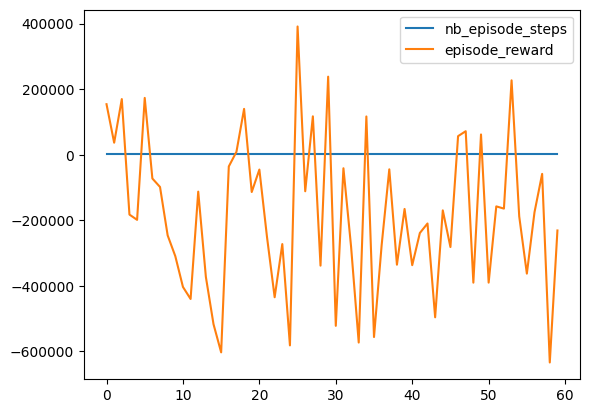

In [2]:
# 学習した重みをファイルに保存します。
#dqn.save_weights('moving_test.hdf5', overwrite=True)

# 学習したモデルを保存
model.save("./../model/ranking_model_without_g")

# ゲームごとのステップ数と報酬をグラフ化します。
plt.plot(history.history['nb_episode_steps'], label='nb_episode_steps')
plt.plot(history.history['episode_reward'], label='episode_reward')
plt.legend()
plt.show()